In [1]:
from ARRG import *

In [2]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample

In [3]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [4]:
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")

# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(1000)

# Extract the hadron multiplicity
exp_mult = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
sim_mult = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(N_events)])
# Extract the transverse mass
sim_mT   = np.sqrt(sim_hadrons[:,:,0]**2 + sim_hadrons[:,:,1]**2 + sim_hadrons[:,:,4]**2)

# Convert into torch objects
sim_mult          = torch.Tensor(sim_mult[0:N_events].copy())
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy())
sim_mT            = torch.Tensor(sim_mT[0:N_events].copy())
exp_mult          = torch.Tensor(exp_mult[0:N_events].copy())

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental multiplicity shape:', exp_mult.shape)
print('Simulated multiplicity shape:', sim_mult.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated mT shape:', sim_mT.shape)

# Prepare data for DataLoader
sim_mult          = ObservableDataset(sim_mult)
sim_accept_reject = ObservableDataset(sim_accept_reject)
sim_mT            = ObservableDataset(sim_mT)
exp_mult          = ObservableDataset(exp_mult)

Experimental observable shape: (1000000, 50, 5)
Simulated observable shape: (1000000, 50, 5)
Simulated z shape: (1000000, 50, 100)
Experimental multiplicity shape: torch.Size([1000])
Simulated multiplicity shape: torch.Size([1000])
Simulated z shape: torch.Size([1000, 50, 100])
Simulated mT shape: torch.Size([1000, 50])


In [5]:
# Set batch size -- set it eqaul to the number of events, we only want one 'batch'
batch_size = N_events

# Initialize data-loaders
sim_observable_dataloader    = DataLoader(sim_mult,          batch_size = batch_size, shuffle = False)
sim_accept_reject_dataloader = DataLoader(sim_accept_reject, batch_size = batch_size, shuffle = False)
sim_mT_dataloader            = DataLoader(sim_mT,            batch_size = batch_size, shuffle = False)
exp_observable_dataloader    = DataLoader(exp_mult,          batch_size = batch_size, shuffle = False)

In [6]:
print('Size of sim_observable_dataloader:', len(sim_observable_dataloader.dataset))
print('Size of sim_accept_reject_dataloader:', len(sim_accept_reject_dataloader.dataset))
print('Size of sim_mT_dataloader:', len(sim_mT_dataloader.dataset))
print('Size of exp_observable_dataloader:', len(exp_observable_dataloader.dataset))

Size of sim_observable_dataloader: 1000
Size of sim_accept_reject_dataloader: 1000
Size of sim_mT_dataloader: 1000
Size of exp_observable_dataloader: 1000


In [7]:
# Training hyperparameters
over_sample_factor = 10.0
# The flow map will be dependent on the learning rate
learning_rate = 0.01
# Length of event buffer
dim_multiplicity  = sim_accept_reject_dataloader.dataset.data.shape[1]
dim_accept_reject = sim_accept_reject_dataloader.dataset.data.shape[2]

print('Each event has been zero-padded to a length of', dim_multiplicity)
print('Each emission has been zero-padded to a length of', dim_accept_reject)

# Define base parameters of simulated data (a, b)
params_base = torch.tensor([0.72, 0.88])
# Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

Each event has been zero-padded to a length of 50
Each emission has been zero-padded to a length of 100


In [8]:
print('Initial a_b grid shape:', a_b_init.shape)

Initial a_b grid shape: torch.Size([100, 2])


In [9]:
# Irrelevant parameters for the flow plot that must be initialized for the ARRG class
epochs = 1
over_sample_factor = 10.0
learning_rate = 0.01

# Create an ARRG instance
ARRG = ARRG(epochs = epochs, dim_multiplicity = dim_multiplicity, dim_accept_reject = dim_accept_reject, over_sample_factor = over_sample_factor,
			params_base = params_base, sim_observable_dataloader = sim_observable_dataloader, sim_kinematics_z_dataloader = sim_accept_reject_dataloader, 
			sim_kinematics_mT_dataloader = sim_mT_dataloader, exp_observable_dataloader = exp_observable_dataloader, print_details = False, 
			results_dir = None, params_init = None)

tensor([0.7200, 0.8800])


In [10]:
# Set the optimizer
optimizer = torch.optim.Adam(ARRG.weight_nexus.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(macroscopic_trainer.weight_nexus.parameters(), lr=learning_rate)

# Generate gradients!
a_b_gradients = ARRG.ARRG_flow(optimizer, a_b_init)

100%|█████████████████████████████████████████████████████████████| 100/100 [27:48<00:00, 16.69s/it]


In [11]:
print(a_b_gradients)

[[ 0.00716783 -0.00216482]
 [ 0.00621894 -0.00170791]
 [ 0.00523804 -0.00123449]
 [ 0.00422252 -0.00074148]
 [ 0.00316959 -0.00022614]
 [ 0.00207666  0.00031389]
 [ 0.00094116  0.00088053]
 [-0.00023928  0.00147526]
 [-0.00146682  0.00209915]
 [-0.00274341  0.00275288]
 [ 0.01025437 -0.00309283]
 [ 0.00931983 -0.00266252]
 [ 0.00836129 -0.00221838]
 [ 0.00737606 -0.00175739]
 [ 0.00636128 -0.00127685]
 [ 0.00531415 -0.0007743 ]
 [ 0.00423202 -0.00024769]
 [ 0.00311229  0.00030465]
 [ 0.00195269  0.00088401]
 [ 0.00075104  0.00149124]
 [ 0.01318911 -0.00401418]
 [ 0.01226158 -0.00360262]
 [ 0.01131765 -0.00317997]
 [ 0.01035451 -0.00274336]
 [ 0.00936926 -0.00229007]
 [ 0.0083589  -0.0018176 ]
 [ 0.00732068 -0.00132371]
 [ 0.00625189 -0.00080663]
 [ 0.00515012 -0.00026483]
 [ 0.00401312  0.00030273]
 [ 0.01598216 -0.00493536]
 [ 0.01505546 -0.00453521]
 [ 0.01411944 -0.00412674]
 [ 0.01317117 -0.0037073 ]
 [ 0.0122077  -0.00327418]
 [ 0.01122599 -0.00282476]
 [ 0.01022315 -0.00235674]
 

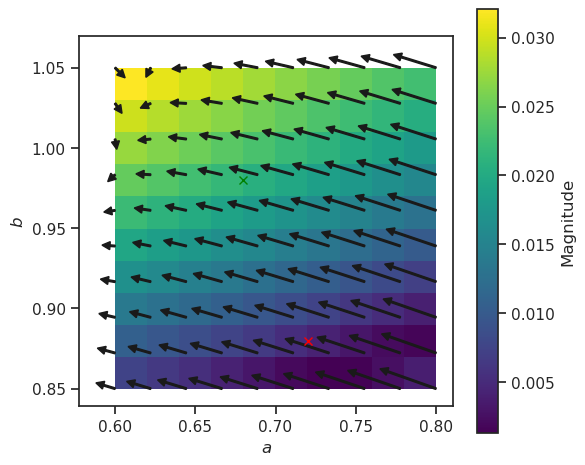

In [12]:
# Clone a_b_init into numpy array
a_b = a_b_init.detach().numpy()

import matplotlib.colors as mcolors

# Calculate the magnitude of each vector in a_b_gradients
magnitudes = np.linalg.norm(a_b_gradients, axis=1)

fig, ax = plt.subplots(1,1,figsize=(6,5))

# Set the background color based on the magnitude
# Normalize the magnitude to use it with the colormap
norm = mcolors.Normalize(vmin=np.min(magnitudes), vmax=np.max(magnitudes))
cmap = plt.cm.viridis  # Choose a colormap

# Assuming magnitudes can be reshaped into a grid directly for simplicity
# In a real scenario, you might need to interpolate these values onto a grid
grid_shape = (int(np.sqrt(len(magnitudes))), int(np.sqrt(len(magnitudes))))
magnitudes_grid = magnitudes.reshape(grid_shape)

# Create a heatmap of the gradient magnitudes
heatmap = ax.imshow(magnitudes_grid, cmap=cmap, norm=norm, origin='lower', extent=(np.min(a_b[:, 0]), np.max(a_b[:, 0]), np.min(a_b[:, 1]), np.max(a_b[:, 1])))


# Add a colorbar to show the magnitude scale
fig.colorbar(heatmap, ax=ax, label='Magnitude')

# Plot arrows for each point and direction
for point, gradient in zip(a_b, a_b_gradients):
    ax.arrow(point[0], point[1], -gradient[0], -gradient[1], head_width=0.005, head_length=0.005, fc='k', ec='k')

a_b_target = np.array([0.68, 0.98]) # Monash
ax.plot(a_b_target[0], a_b_target[1], 'x', color='green', label = 'Target')#label = r'$\mathrm{Target}$')
ax.plot(ARRG.params_base[0].clone().detach().numpy(), ARRG.params_base[1].clone().detach().numpy(), 'x', color = 'red', label = 'Base')#label = r'$\mathrm{Base}$'

ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

fig.tight_layout()
fig.savefig('ARRG_flow.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('ARRG_flow.png', dpi=300, bbox_inches='tight', pad_inches=0.1)